Francesco Angiulli (897415), Eleonora Brambatti (858098), Marta Privitera (898017)

# Best models

We mount the drive on Google Colab account

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We download the dataset of flowers from the website and we extract the files from the zip.

In [ ]:
import urllib.request
import tarfile

# URL del dataset
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"

# Percorso di destinazione per il download
file_name = "flower_photos.tgz"

# Download del file
urllib.request.urlretrieve(url, file_name)

# Estrazione del file
tar = tarfile.open(file_name)
tar.extractall()
tar.close()

We import some useful libraries and we set the seeds.

In [ ]:
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import numpy as np

from tensorflow.keras import layers
import random as python_random


np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

We import 'glob' to check the folder content

In [ ]:
from glob import glob
flowers = glob("flower_photos/*/", recursive = True)
flowers

['flower_photos/daisy/',
 'flower_photos/roses/',
 'flower_photos/tulips/',
 'flower_photos/dandelion/',
 'flower_photos/sunflowers/']

We import os.path, to reach the path of each subfolder and see the number of photo for each folder

In [ ]:
import os, os.path

for i in flowers:
  print (f'{i}''\nnumber of photo: ',len([name for name in os.listdir(i) if os.path.isfile(os.path.join(i, name))]),'\n')

flower_photos/daisy/
number of photo:  633 

flower_photos/roses/
number of photo:  641 

flower_photos/tulips/
number of photo:  799 

flower_photos/dandelion/
number of photo:  898 

flower_photos/sunflowers/
number of photo:  699 



We split the dataset folder in order to create the train (0.7), the validation (0.2) and the test (0.1) set.

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('flower_photos', output="output", seed=1337, ratio=(0.7, 0.2, 0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3670 files [00:03, 1033.00 files/s]


We set the variables for the paths to the train, validation and test set folders.

In [ ]:
path_train='/content/output/train/'
path_val='/content/output/val/'
path_test='/content/output/test/'

We define the train_dataset

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(path_train,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)

Found 2567 files belonging to 5 classes.


We define the validation set

In [ ]:
val_dataset = keras.preprocessing.image_dataset_from_directory(path_val,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)

Found 731 files belonging to 5 classes.


We define the test set

In [ ]:
test_dataset = keras.preprocessing.image_dataset_from_directory(path_test,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)

Found 372 files belonging to 5 classes.


We set the class names and their number

In [ ]:
class_names = train_dataset.class_names
num_classes=5

Show data , randomly, into train dataset

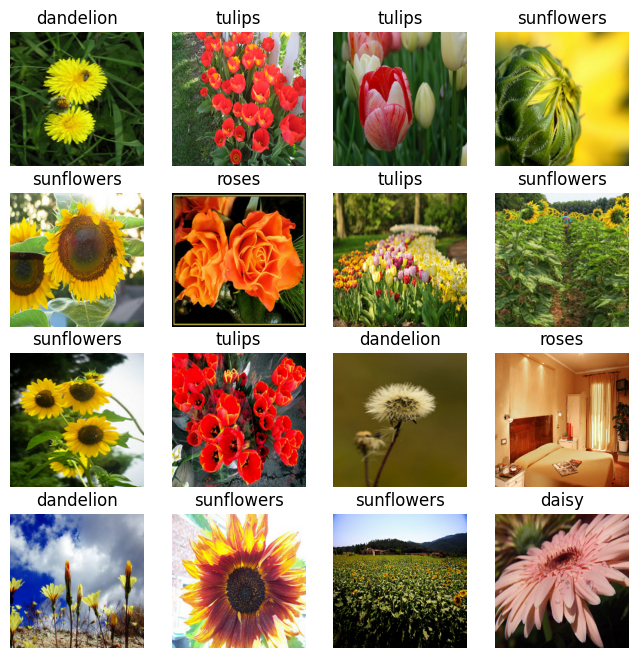

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
    plt.axis("off")

We set the features of the data augmentation adopted on the training set.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

Show how work data augmentation on a single data

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(20, 20))
  first_image = image[1]
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

#From Scratch

Best parameters for training:



*  learning_rate=0.001
*  BatchNormalization before each layer of the last level of the network.
* loss= categorical crossentropy with regularizer l2 = 0.001.
* Dropout of 0.3 on the next-to-last dense layers of (500 nodes) and (300 nodes).
* Adam optimizer
* batch_size=32.
* epochs=40


Preprocessing
* Rescaling the images

**Definition of the architecture**

In [ ]:
#Size of input images
inputs = keras.Input((224,224,3))
x = inputs

#Data Augmentation
x = data_augmentation(x)

#callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#A preprocessing layer which rescales input values to a new range.
x = keras.layers.Rescaling(1./255)(x) #To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.

x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Dropout(0.3)(x)
x = keras.layers.GlobalMaxPooling2D()(x)

#Reshaping layer
x = keras.layers.Flatten()(x) #Does not affect the batch size.

x = keras.layers.Dense(500, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(300, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)


#output of the net
outputs = keras.layers.Dense(num_classes, activation="softmax",kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
netScratch = keras.Model(inputs, outputs)

**Compile the model**

In [ ]:
netScratch.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

**Summarize the model**

In [ ]:
netScratch.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                           

**Train the model**

In [ ]:
history_Scratch = netScratch.fit(train_dataset,
                 epochs=40,
                 validation_data=val_dataset)

Epoch 1/40
81/81 [==============================] - 40s 277ms/step - loss: 1.8002 - accuracy: 0.4246 - val_loss: 1.5442 - val_accuracy: 0.2572
Epoch 2/40
81/81 [==============================] - 17s 199ms/step - loss: 1.1325 - accuracy: 0.5430 - val_loss: 1.5525 - val_accuracy: 0.2462
Epoch 3/40
81/81 [==============================] - 17s 210ms/step - loss: 1.0468 - accuracy: 0.5875 - val_loss: 1.4173 - val_accuracy: 0.3037
Epoch 4/40
81/81 [==============================] - 17s 201ms/step - loss: 0.9405 - accuracy: 0.6276 - val_loss: 1.3278 - val_accuracy: 0.4036
Epoch 5/40
81/81 [==============================] - 17s 202ms/step - loss: 0.9075 - accuracy: 0.6420 - val_loss: 1.1546 - val_accuracy: 0.5376
Epoch 6/40
81/81 [==============================] - 16s 193ms/step - loss: 0.8869 - accuracy: 0.6467 - val_loss: 0.9981 - val_accuracy: 0.6566
Epoch 7/40
81/81 [==============================] - 17s 200ms/step - loss: 0.8649 - accuracy: 0.6615 - val_loss: 0.8906 - val_accuracy: 0.7059

**Plot accuracy and Loss on train and validation sets**

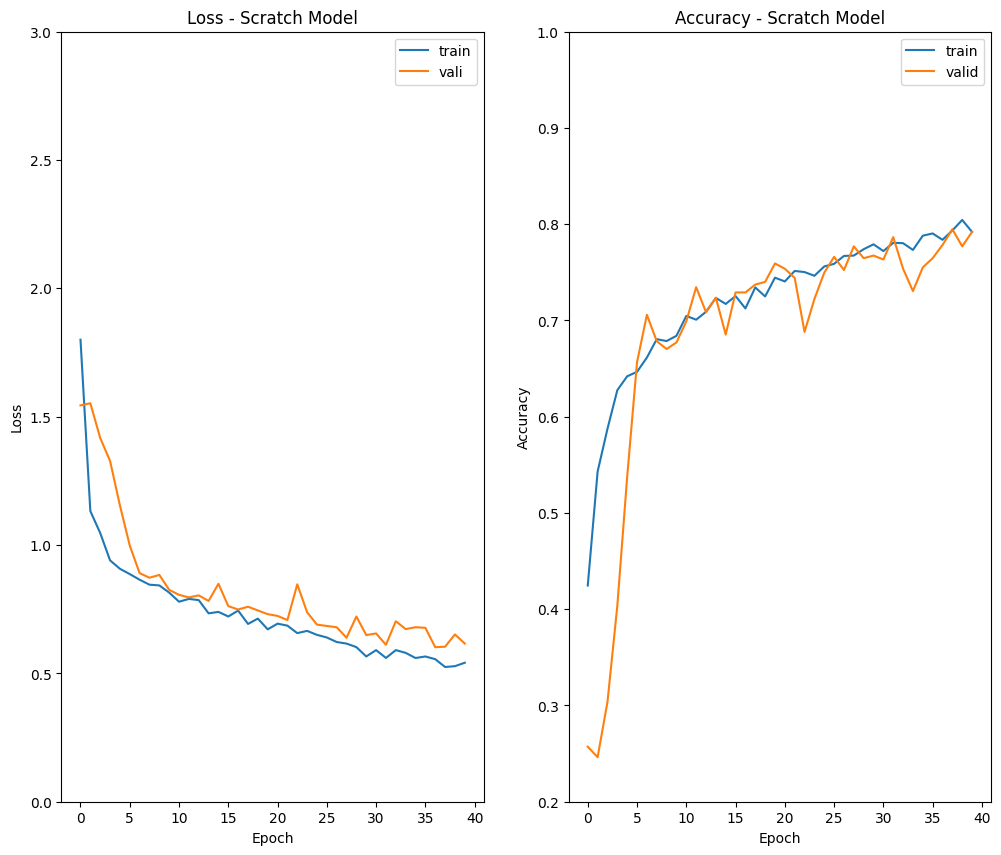

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.title('Loss - Scratch Model')
plt.plot(history_Scratch.history['loss'])
plt.plot(history_Scratch.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'vali'])

plt.subplot(1, 2, 2)
plt.title('Accuracy - Scratch Model')
plt.plot(history_Scratch.history['accuracy'])
plt.plot(history_Scratch.history['val_accuracy'])
plt.ylim([0.2, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

**Diagram of the net structure**

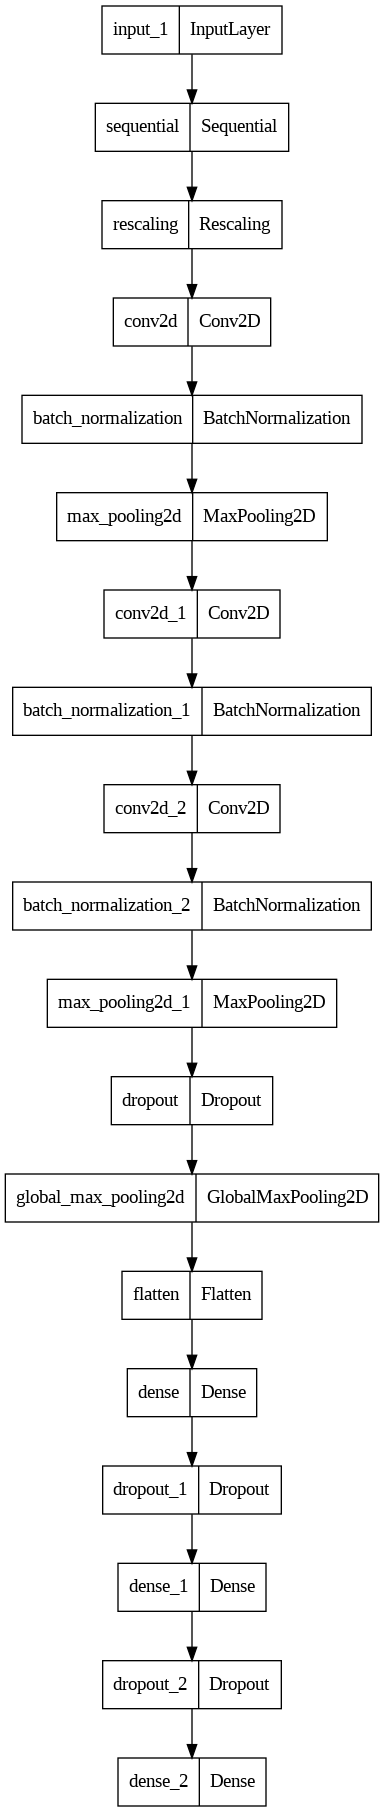

In [ ]:
keras.utils.plot_model(netScratch, to_file="netScratch.png")

**Evaluation on test set**

In [ ]:
netScratch.evaluate(test_dataset)

12/12 [==============================] - 1s 80ms/step - loss: 0.6114 - accuracy: 0.7608


[0.6114383339881897, 0.7607526779174805]

**Save the model**

In [ ]:
netScratch.save('/content/drive/MyDrive/Progetto_DPL/Deep_Learning_Project/Cartella Best Models/FromScratch.h5')

**Number of images missclassified in the test dataset**

In [ ]:
errate=0
for images, labels in test_dataset:
    for i in range( images.shape[0]):
        predictions = netScratch.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
          errate+=1
print(f'Number of images missclassified: {errate}')

Number of images classifacated wrong: 89


**Plot the missclassified images (test set)**

In [ ]:
j=0
plt.figure(figsize=(20, 20))
for images, labels in test_dataset:
    for i in range(images.shape[0]):
        predictions = netScratch.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
          ax = plt.subplot(10, 10, j+1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.ylabel("Predicted: "+class_names[np.argmax(score)])
          plt.title("Actual: "+class_names[np.argmax(labels[i], axis=None, out=None)])
          plt.gca().axes.yaxis.set_ticklabels([])
          plt.gca().axes.xaxis.set_ticklabels([])
          j+=1


Output hidden; open in https://colab.research.google.com to view.

# MobileNet

The best model found using MobileNet's pretrained architecture for predicting classes of the Flowers dataset is the following.

**Best parameters for training**:

1. learning_rate=0.001
2. BatchNormalization before the last and next-to-last level of the network.
3. loss= categorical crossentropy with regularizer l2 = 0.0001.
4. Dropout of 0.5 on the next-to-last dense layer of (128 nodes).
5. Adam optimizer
6. batch_size=32.
7. epochs=40

**Preprocessing**

1. MobileNet preprocessing
2. ImageDataGenerator for rescaling the images.



In [ ]:
# import of libraries needed
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Size of the input images
input_shape = (224, 224, 3)

# Number of classes in the dataset
num_classes = 5

# Load the pretrained MobileNet architecture
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the weights of the pretrained architecture
for layer in base_model.layers:
    layer.trainable = False

# Add custom fully connected layers with L2 regularization and dropout
regularization = tf.keras.regularizers.l2(0.0001)  # regularization coefficient
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
x = data_augmentation(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularization)(x)
x = Dropout(0.5)(x)  # Adding dropout
x = BatchNormalization()(x)  # Adding batch normalization
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
modelMobileNet = Model(inputs=inputs, outputs=predictions)

# Define the optimizer with the initial learning rate
optimizer = Adam(learning_rate=0.001)

# Define the optimizer with the initial learning rate
modelMobileNet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
modelMobileNet.summary()

# Define the data paths
data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir +'/test'

# Create images for training and validation with rescale feature
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the data generators
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
history_MobileNet= modelMobileNet.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=[callback]
)

evaluate_test = loss, accuracy = modelMobileNet.evaluate(test_generator)

17225924/17225924 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                            

**Train vs Validation plots of accuracy and loss**

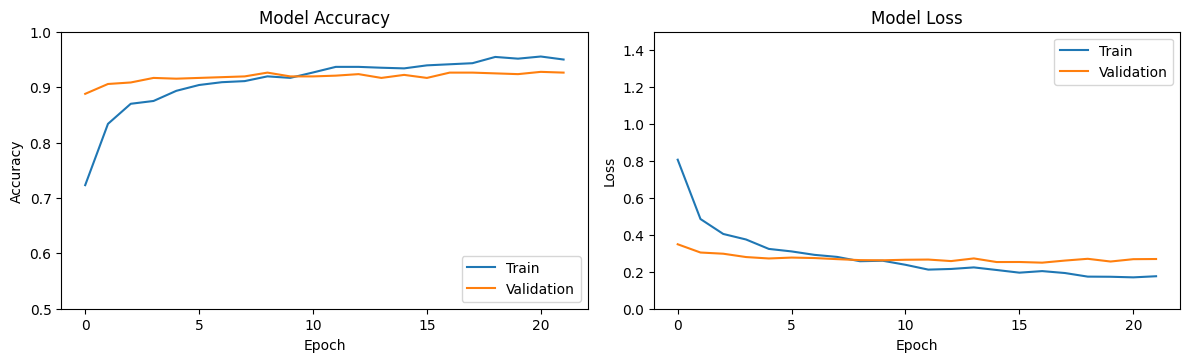

 Accuracy Diff Mean  Loss Diff Mean
             0.0277          0.0783


In [ ]:
import pandas as pd

# Create the DataFrame for the final table
table_data = {'Accuracy Diff Mean': [], 'Loss Diff Mean': []}

# Calculate the mean differences between accuracies
train_acc_diff = np.abs(np.array(history_MobileNet.history['accuracy']) - np.array(history_MobileNet.history['val_accuracy']))
avg_acc_diff = np.mean(train_acc_diff)

# Calculate the mean differences between losses
train_loss_diff = np.abs(np.array(history_MobileNet.history['loss']) - np.array(history_MobileNet.history['val_loss']))
avg_loss_diff = np.mean(train_loss_diff)

# Add the values to the table
table_data['Accuracy Diff Mean'].append(avg_acc_diff)
table_data['Loss Diff Mean'].append(avg_loss_diff)

# Plot accuracy and loss
plt.figure(figsize=(12, 10))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(history_MobileNet.history['accuracy'])
plt.plot(history_MobileNet.history['val_accuracy'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.5, 1])

# Accuracy Legend
acc_legend_text = ['Train', 'Validation']
plt.legend(acc_legend_text, loc='lower right')


# Loss
plt.subplot(3, 2, 2)
plt.plot(history_MobileNet.history['loss'])
plt.plot(history_MobileNet.history['val_loss'])
plt.title(f'Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 1.5])

# Loss Legend
loss_legend_text = ['Train', 'Validation']
plt.legend(loss_legend_text, loc='upper right')

plt.tight_layout()
plt.show()

# Create the final DataFrame
table_df = pd.DataFrame(table_data)

# Print the table with improved formatting
print(table_df.to_string(index=False, float_format='%.4f'))

**Diagram of the net structure**

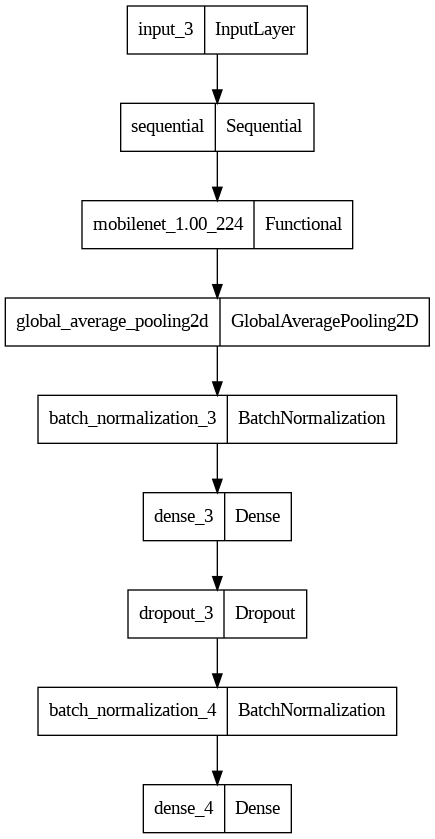

In [ ]:
keras.utils.plot_model(modelMobileNet, to_file="MobileNet.png")

**Evaluation of Accuracy and Loss on the test set**

In [ ]:
print(evaluate_test)

[0.2694697678089142, 0.9220430254936218]


**Save the model**

In [ ]:
modelMobileNet.save('/content/drive/MyDrive/Progetto_DPL/Deep_Learning_Project/Cartella Best Models/MobileNet.h5')

**Check the number of images in the test set**

In [ ]:
num_images_test = test_generator.n
print("Number of images in the test generator:", num_images_test)


Number of images in the test generator: 372


**Check the labels of the images in the test set**

In [ ]:
class_labels = list(test_generator.class_indices.keys())
print(class_labels)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**predictions by the model**

In [ ]:
predictions = modelMobileNet.predict(test_generator)

12/12 [==============================] - 3s 186ms/step


1/1 [==============================] - 1s 666ms/step
32
1/1 [==============================] - 0s 38ms/step
64
1/1 [==============================] - 0s 47ms/step
96
1/1 [==============================] - 0s 34ms/step
128
1/1 [==============================] - 0s 41ms/step
160
1/1 [==============================] - 0s 34ms/step
192
1/1 [==============================] - 0s 35ms/step
224
1/1 [==============================] - 0s 40ms/step
256
1/1 [==============================] - 0s 43ms/step
288
1/1 [==============================] - 0s 42ms/step
320
1/1 [==============================] - 0s 36ms/step
352
1/1 [==============================] - 0s 439ms/step
372
Numero di immagini classificate erroneamente: 29
Numero totale di immagini: 372


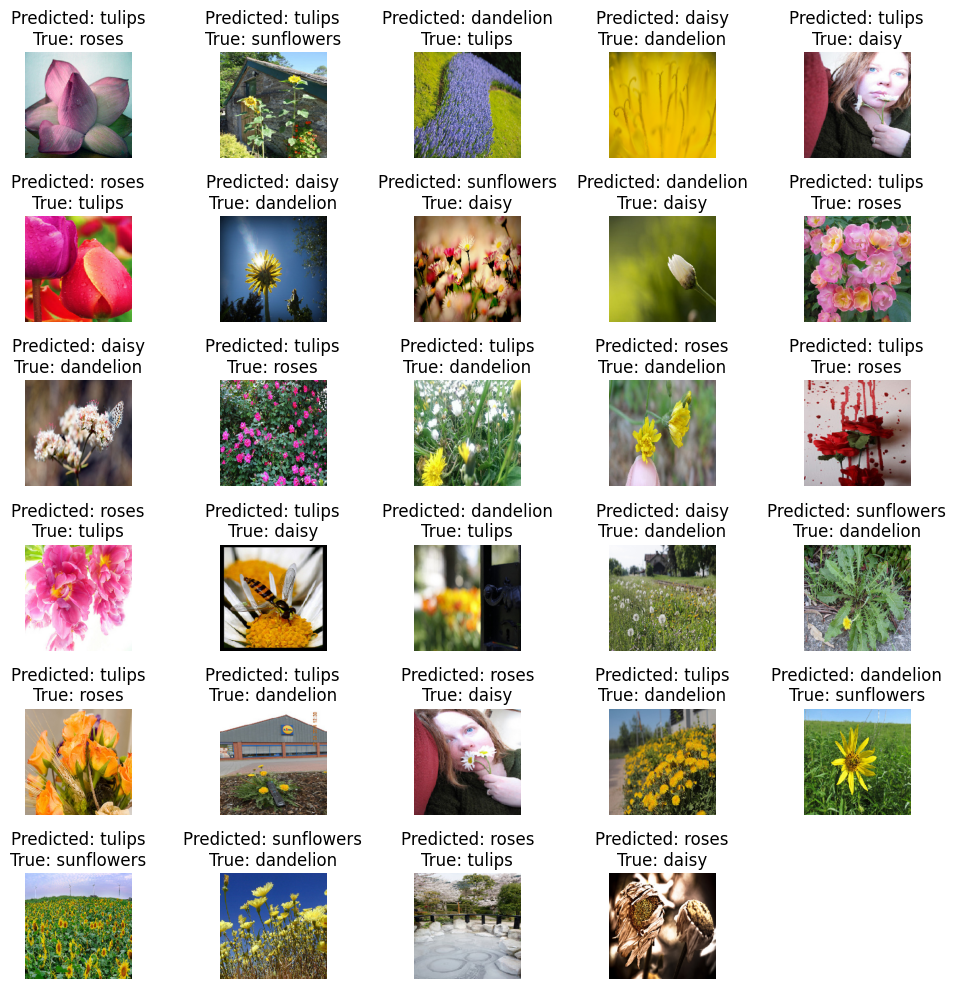

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

errate = 0
total_images = 0
batch_size = test_generator.batch_size

misclassified_images = []
misclassified_predicted_labels = []
misclassified_true_labels = []

for images, labels in test_generator:
    predictions = modelMobileNet.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    misclassified_indices = np.where(predicted_labels != true_labels)[0]
    misclassified_images.extend(images[misclassified_indices])
    misclassified_predicted_labels.extend(predicted_labels[misclassified_indices])
    misclassified_true_labels.extend(true_labels[misclassified_indices])

    errate += np.sum(predicted_labels != true_labels)
    total_images += len(images)
    print(total_images)
    if total_images >= len(test_generator) * batch_size - len(test_generator):
        # Tutte le immagini di test sono state processate
        break

print("Numero di immagini classificate erroneamente:", errate)
print("Numero totale di immagini:", total_images)

num_misclassified = len(misclassified_images)
num_rows = int(np.ceil(np.sqrt(num_misclassified)))
num_cols = int(np.ceil(num_misclassified / num_rows))

flower_names = class_labels  # Sostituisci con i nomi dei fiori corretti

plt.figure(figsize=(10, 10))
for i, (image, predicted_label, true_label) in enumerate(zip(misclassified_images, misclassified_predicted_labels, misclassified_true_labels)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(np.clip(image * 255.0, 0, 255).astype('uint8'))
    plt.title(f"Predicted: {flower_names[predicted_label]}\nTrue: {flower_names[true_label]}")  # Aggiungi l'etichetta predetta e vera nel titolo
    plt.axis('off')

plt.tight_layout()
plt.show()


# VGG
The best vgg model has the following characterists:

- vgg preprocessing

Parameters:
- learning rate = 0.001
- regularizer = 0.0001
- number of dense nodes = 128
- optimizer = Adam
- batch size = 32
- epochs = 40 (with callback)



**Definition of the net architecture**

In [ ]:
from keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
# Define the input shape of images

vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

# callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = data_augmentation(x)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
modelVGG = keras.Model(inputs=inputs, outputs=outputs)


# Compile the model
modelVGG.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

modelVGG.summary()



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0   

In [ ]:
# train the model
history_vgg = modelVGG.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])


Epoch 1/40
81/81 [==============================] - 18s 194ms/step - loss: 1.1802 - accuracy: 0.6023 - val_loss: 0.5675 - val_accuracy: 0.7975
Epoch 2/40
81/81 [==============================] - 16s 192ms/step - loss: 0.6496 - accuracy: 0.7713 - val_loss: 0.4841 - val_accuracy: 0.8386
Epoch 3/40
81/81 [==============================] - 17s 204ms/step - loss: 0.5863 - accuracy: 0.7986 - val_loss: 0.4455 - val_accuracy: 0.8509
Epoch 4/40
81/81 [==============================] - 17s 192ms/step - loss: 0.4823 - accuracy: 0.8278 - val_loss: 0.4194 - val_accuracy: 0.8618
Epoch 5/40
81/81 [==============================] - 19s 223ms/step - loss: 0.4736 - accuracy: 0.8414 - val_loss: 0.4159 - val_accuracy: 0.8618
Epoch 6/40
81/81 [==============================] - 16s 187ms/step - loss: 0.4182 - accuracy: 0.8547 - val_loss: 0.4215 - val_accuracy: 0.8646
Epoch 7/40
81/81 [==============================] - 17s 207ms/step - loss: 0.3909 - accuracy: 0.8640 - val_loss: 0.4213 - val_accuracy: 0.8673

Training and Validation Loss and Accuracy

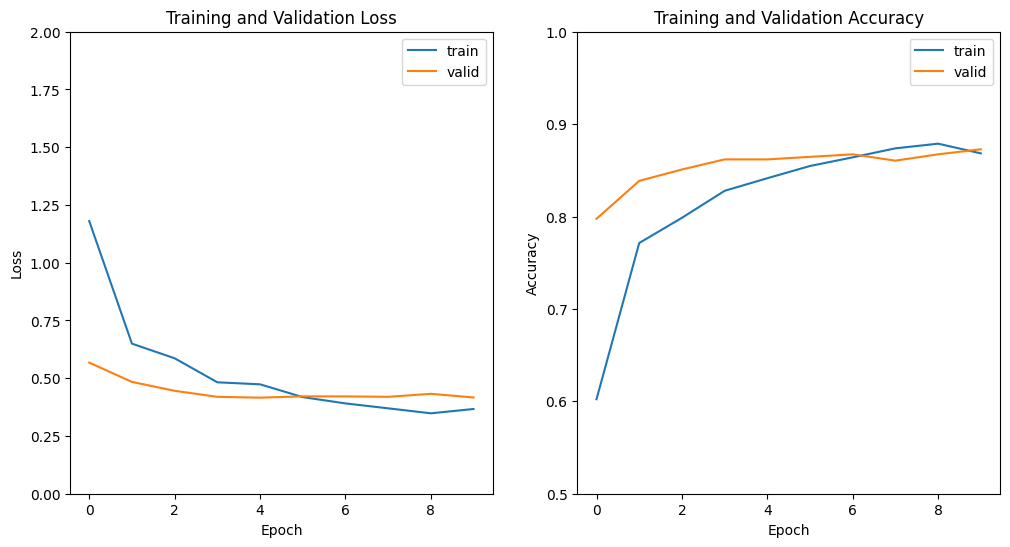

In [ ]:
# Visualization of the learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Loss');

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Accuracy');

**Diagram of the net architecture**

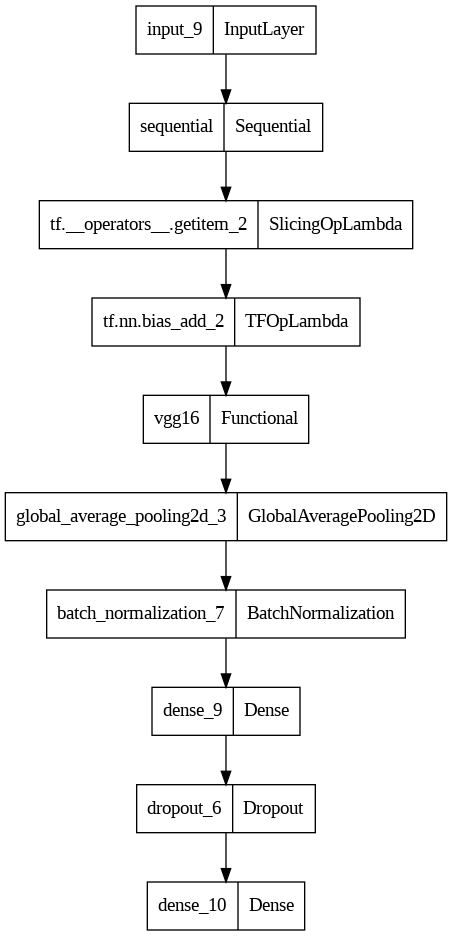

In [ ]:
keras.utils.plot_model(modelVGG, to_file="VGG.png")

Evaluation on test dataset

In [ ]:
loss, accuracy = modelVGG.evaluate(test_dataset)

12/12 [==============================] - 5s 405ms/step - loss: 0.3462 - accuracy: 0.8925


Save the model

In [ ]:
modelVGG.save('/content/drive/MyDrive/Progetto_DPL/Deep_Learning_Project/Cartella Best Models/VGG.h5')

Number of missclassified images

In [ ]:
errate=0
for images, labels in test_dataset:
    for i in range( images.shape[0]):
        predictions = modelVGG.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
          errate+=1
print(f'Number of images classifacated wrong: {errate}')

Number of images classifacated wrong: 40


Plot the missclassified images

In [ ]:
j=0
plt.figure(figsize=(20, 20))
for images, labels in test_dataset:
    for i in range(images.shape[0]):
        predictions = modelVGG.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
          ax = plt.subplot(8, 8, j+1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.ylabel("Predicted: "+class_names[np.argmax(score)])
          plt.title("Actual: "+class_names[np.argmax(labels[i], axis=None, out=None)])
          plt.gca().axes.yaxis.set_ticklabels([])
          plt.gca().axes.xaxis.set_ticklabels([])
          j+=1

Output hidden; open in https://colab.research.google.com to view.

# ResNet
The best ResNet model has the following characterists:

- resnet preprocessing

Parameters:
- learning rate = 0.001
- regularizer = 0.0001
- number of dense nodes = 128
- optimizer = Adam
- batch size = 32
- epochs = 40 (with callback)


**Definition of the net architecture**

In [ ]:
# Import of necessary library
from tensorflow.keras.applications import ResNet50

# callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in resnet_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = data_augmentation(x)
x = keras.applications.resnet.preprocess_input(x)
x = resnet_model(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
modelResNet = keras.Model(inputs=inputs, outputs=outputs)

from tensorflow.keras.optimizers import Adam

# Compile the model

modelResNet.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Summary of the model
modelResNet.summary()



94765736/94765736 [==============================] - 3s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                            

In [ ]:
# train the model
history_resnet = modelResNet.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])


Epoch 1/40
81/81 [==============================] - 23s 204ms/step - loss: 0.8345 - accuracy: 0.7589 - val_loss: 0.3746 - val_accuracy: 0.8796
Epoch 2/40
81/81 [==============================] - 14s 168ms/step - loss: 0.4752 - accuracy: 0.8516 - val_loss: 0.3291 - val_accuracy: 0.9001
Epoch 3/40
81/81 [==============================] - 13s 155ms/step - loss: 0.4030 - accuracy: 0.8757 - val_loss: 0.3223 - val_accuracy: 0.9166
Epoch 4/40
81/81 [==============================] - 13s 150ms/step - loss: 0.3054 - accuracy: 0.9081 - val_loss: 0.3675 - val_accuracy: 0.9111
Epoch 5/40
81/81 [==============================] - 13s 153ms/step - loss: 0.2796 - accuracy: 0.9108 - val_loss: 0.3533 - val_accuracy: 0.9138
Epoch 6/40
81/81 [==============================] - 13s 155ms/step - loss: 0.2633 - accuracy: 0.9190 - val_loss: 0.3496 - val_accuracy: 0.9029
Epoch 7/40
81/81 [==============================] - 13s 154ms/step - loss: 0.2295 - accuracy: 0.9268 - val_loss: 0.3469 - val_accuracy: 0.9152

Training and Validation Loss and Accuracy

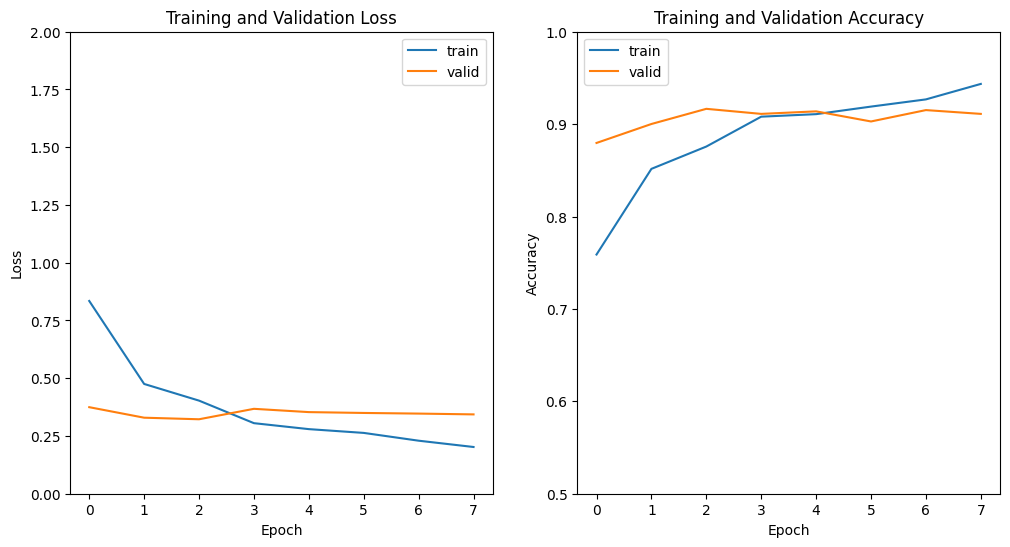

In [ ]:
# Visualization of the learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Loss');

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Accuracy');

Diagram of the net architecture

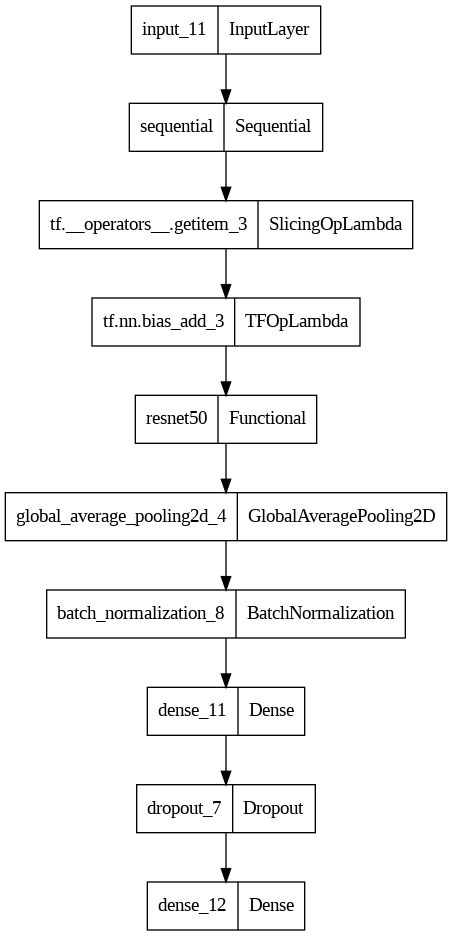

In [ ]:
keras.utils.plot_model(modelResNet, to_file="ResNet.png")

Evaluation on test dataset

In [ ]:
loss, accuracy = modelResNet.evaluate(test_dataset)

12/12 [==============================] - 3s 184ms/step - loss: 0.2415 - accuracy: 0.9167


Save the model

In [ ]:
modelResNet.save('/content/drive/MyDrive/Progetto_DPL/Deep_Learning_Project/Cartella Best Models/ResNet.h5')

Number of missclassified images

In [ ]:
errate=0
for images, labels in test_dataset:
    for i in range( images.shape[0]):
        predictions = modelResNet.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
          errate+=1
print(f'Number of images classifacated wrong: {errate}')

Number of images classifacated wrong: 31


Plot the missclassified images of the test set

In [ ]:
j=0
plt.figure(figsize=(20, 20))
for images, labels in test_dataset:
    for i in range(images.shape[0]):
        predictions = modelResNet.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
          ax = plt.subplot(8, 8, j+1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.ylabel("Predicted: "+class_names[np.argmax(score)])
          plt.title("Actual: "+class_names[np.argmax(labels[i], axis=None, out=None)])
          plt.gca().axes.yaxis.set_ticklabels([])
          plt.gca().axes.xaxis.set_ticklabels([])
          j+=1

Output hidden; open in https://colab.research.google.com to view.

# Comparing models

graphs for comparison
- train loss + train acc
- val loss + val acc

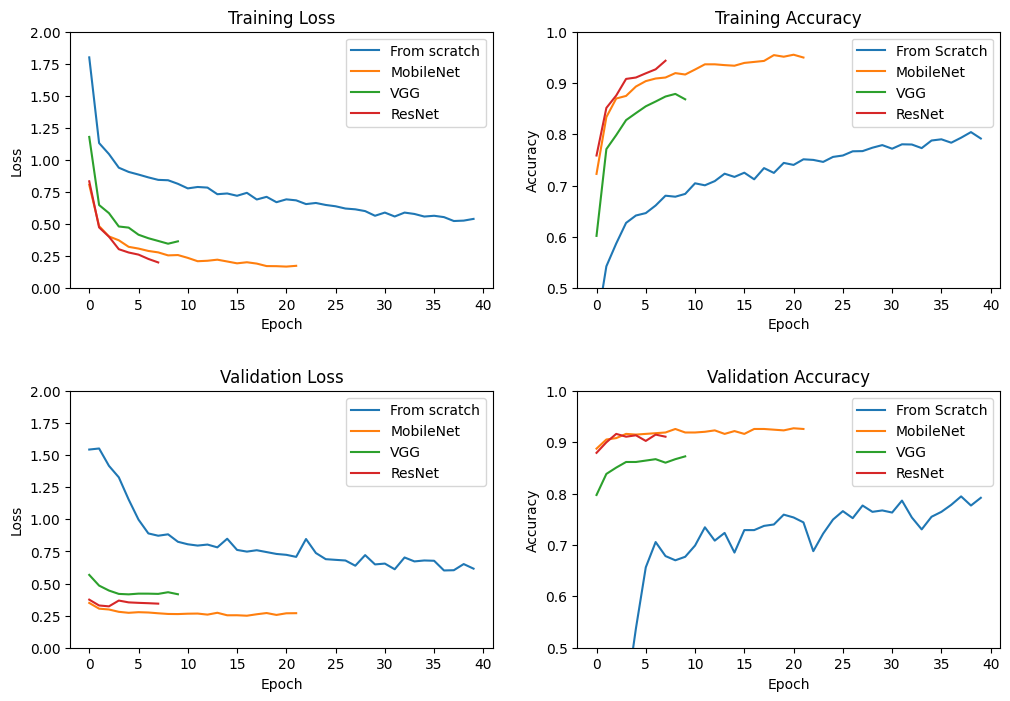

In [ ]:
# Visualization of the learning curves
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_Scratch.history['loss'], label='From scratch')
plt.plot(history_MobileNet.history['loss'], label='MobileNet')
plt.plot(history_vgg.history['loss'], label='VGG')
plt.plot(history_resnet.history['loss'], label='ResNet')
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss');

plt.subplot(2, 2, 2)
plt.plot(history_Scratch.history['accuracy'], label='From Scratch')
plt.plot(history_MobileNet.history['accuracy'], label='MobileNet')
plt.plot(history_vgg.history['accuracy'], label='VGG')
plt.plot(history_resnet.history['accuracy'], label='ResNet')
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy');



plt.subplot(2, 2, 3)
plt.plot(history_Scratch.history['val_loss'], label='From scratch')
plt.plot(history_MobileNet.history['val_loss'], label='MobileNet')
plt.plot(history_vgg.history['val_loss'], label='VGG')
plt.plot(history_resnet.history['val_loss'], label='ResNet')
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss');

plt.subplot(2, 2, 4)
plt.plot(history_Scratch.history['val_accuracy'], label='From Scratch')
plt.plot(history_MobileNet.history['val_accuracy'], label='MobileNet')
plt.plot(history_vgg.history['val_accuracy'], label='VGG')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet')
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy');

plt.subplots_adjust(hspace=0.4)